_______
Import some stuff:

In [1]:
import os
import torch
import glob
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
#import nbimporter
#from wrangling import prep_dataframe
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pydicom
import os
import numpy as np
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import math
from torch.distributions.normal import Normal
import torch.cuda

In [3]:
def prep_dataframe(directory, csv):   
    diagnoses = pd.read_csv(csv)
    diagnoses = diagnoses.to_numpy()
    more = np.empty((len(diagnoses), 3), dtype = 'U18')
    for x in range(len(diagnoses)):
        more[x][0] = diagnoses[x][0][3:12]
        more[x][1] = diagnoses[x][0][13:]

    more[:,2] = diagnoses[:,1]

    #test_list = os.listdir(directory)
    test_list = glob.glob("/home/wustl/brooks.kennedy/stage_2_train/*.dcm")[0:100]
    #print(test_list)
    image_arrays = np.zeros([512, 512])
    df = pd.DataFrame(columns = ["Image", "ID", "Diagnoses"])

    for file in test_list:
        if(file != ".DS_Store"):
            try:
                dataset = pydicom.dcmread(file, force = True)
                diagnoses = more[:,1:][more[:,0]==file[44:53]]
                filtered_diagnoses = diagnoses[:,0][diagnoses[:,1]=='1']
                if filtered_diagnoses.size != 0:
                    df = df.append({"Image": dataset.pixel_array, "ID": file[44:53], 
                                    "Diagnoses": filtered_diagnoses}, ignore_index = True)
            except:
                print("Error with file "+file)  
    return df

In [4]:
torch.cuda.device_count()

0

_____
Get the data:

In [4]:
train_data_ = prep_dataframe("/home/wustl/brooks.kennedy/stage_2_train", "/home/wustl/brooks.kennedy/stage_2_train.csv")

In [ ]:
train_data_

In [5]:
#train_y = train_data_['Hemmorhage']
train_x = train_data_['Image']
ids = train_data_['ID']

#convert training images, target data, ids to numpy arrays
train_x = train_x.to_numpy()
#train_y = train_y.to_numpy()
ids = ids.to_numpy()
for x in range(0, len(train_x)): #filter out incorrectly shaped images
    if (train_x[x].shape != (512, 512)):
        train_x = np.delete(train_x, x)
        #train_y = np.delete(train_y, x)
        ids = np.delete(ids, x)
train_x = np.array([np.array(x) for x in train_x])

#convert training images to pytorch tensors
train_x = train_x.reshape(len(train_x), 1, 512, 512)
train_x = train_x.astype('float')
train_x = torch.from_numpy(train_x)

# #convert target data to pytorch tensor
# train_y = train_y.astype('bool')
# train_y = torch.from_numpy(train_y)

______
Display some images:

In [ ]:
# for img in range (0,10):
#     dataset = pydicom.dcmread("stage_2_train/ID_"+train_data['ID'][img]+".dcm")
#     plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
#     plt.show()

_____
Define the generator:

In [6]:
ngpu = 1
class Generator(nn.Module):

    def __init__(self, ngpu):
        super(Generator, self).__init__()   
        self.ngpu = ngpu
#         self.cnn_layers = Sequential(
#             #convolution layer 1
#             Conv2d(16, 4, kernel_size = 3, stride=1, padding=1),
#             BatchNorm2d(4),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size = 2, stride=2),
            
#             #convolution layer 2
#             Conv2d(4, 16, kernel_size = 3, stride=1, padding=1),
#             BatchNorm2d(16),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size = 2, stride=2),
#         )
        self.dense_layer = Sequential (
            nn.Linear(16, 128),
            nn.Linear(128, 256),
            nn.Linear(256, 262144)
        )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        #x = self.cnn_layers(x)
        #x = self.cnn_layers(x)
        #torch.reshape(x, (4, 4))
        x = self.dense_layer(x)
        x = self.relu(x)
        x = torch.reshape(x, (512, 512))
        return x

______
Generate some random noise from a normal distribution with the mean and standard deviation of the original dataset and put it through the generator to produce an image.

(512, 512)

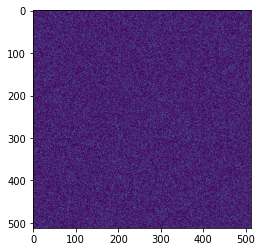

In [7]:
gen = Generator(ngpu)
mu = train_x.mean()
std = train_x.std()
noise = torch.normal(mu, std, size=(1,16))
generated_image = gen(noise)

#display the image
generated_image=generated_image.detach().numpy() 
plt.imshow(  generated_image)
generated_image.shape

In [9]:
def makeFakeData(generator, count, real_data):
    mu = real_data.mean()
    std = real_data.std()
    generated_images = torch.empty(size=(count,1,512,512))
    for i in range(count):
        noise = torch.normal(mu, std, size=(1,16))
        generated_image = gen(noise)
        generated_image = generated_image.reshape((1,1,512,512))
        generated_images[i] = generated_image #torch.cat((generated_images, generated_image), 0)
    return generated_images

gen = Generator(ngpu)
ims = makeFakeData(gen, 5, train_x)
#plt.imshow(ims[0].detach().numpy() )
print(ims.shape)

torch.Size([5, 1, 512, 512])


_____
Define the discriminator:

In [10]:
channels = 1
im_size = 512
noise_size = 16
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(channels, im_size, 4, 2, 1, bias = False),
            #BatchNorm2d(im_size),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            nn.Conv2d(im_size, im_size*2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(im_size*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            nn.Conv2d(im_size*2, im_size*4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(im_size*4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            nn.Conv2d(im_size*4, im_size*8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(im_size*8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(im_size*8, 1, 4, 2, 1),
            nn.Sigmoid()
            
        )

#         self.linear_layers = Sequential(
#             Linear(256*256, 10)
#         )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        #x = x.view(x.size(0), -1)
        #x = self.linear_layers(x)
        return x

In [11]:
dis = Discriminator()
ims.shape
discrim = dis(ims)

In [14]:
discrim[0]

tensor([[[0.5248]]], grad_fn=<SelectBackward>)

_______
Define loss function and optimizer:

In [15]:
#for now, using BCE loss and Adam as the optimizer. look into these more later.

______
Now train:

In [14]:
def train(max_int: int = 128, batch_size: int = 16, training_steps: int = 500):
    #input_length = int(math.log(max_int, 2))

    # run on the GPU, or not
#     if torch.cuda.is_available():
#         #device1 = torch.device("cuda")
#         device1 = torch.device(0)
#         print("Running on the GPU")
#     else:
#         device1 = torch.device("cpu")
#         device2 = torch.device("cpu")
#         print("Running on the CPU")
    
    device1 = torch.device("cuda")
    
    # Models
#     generator = Generator().to(device1)
    generator = Generator(1).cuda(0)
    discriminator = Discriminator().to(device1)

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # loss
    loss = nn.BCELoss()

    for i in range(training_steps):
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()
        
        # GENERATE FAKE DATA FROM RANDOM NOISE
        generated_data = makeFakeData(generator, 100, train_x)

        # real data
        #true_labels, true_data = train_y[0:100], train_x[0:100]
        true_data = train_x[0:100]
        true_labels = [1.0]*100
        true_labels = torch.tensor(true_labels).float()[0:100]
        true_data = torch.tensor(true_data).float()[0:100]

        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        # PREDICTIONS OF THE DISCRIMINATOR ON THE FAKE DATA
        generator_discriminator_out = discriminator(generated_data)
        generator_loss = loss(generator_discriminator_out, true_labels) #USE TRUE LABELS 
        # BACKPROPOGATE ERROR THROUGH JUST THE GENERATOR
        generator_loss.backward()
        generator_optimizer.step()

        # Train the discriminator on the true/generated data
        # 
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, true_labels)

        # add .detach() here think about this
        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(batch_size))
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()
        if (i % 50 == 0):
            #print("Step "+str(i)+": ")
            print(list(map(int, torch.round(generated_data).tolist())))
            #print(int("".join(str(i) for i in torch.round(generated_data).tolist()),2))
    return generator

In [15]:
gen = train()

RuntimeError: CUDA error: out of memory

In [25]:
torch.cuda.get_device_name(0)

'GRID V100S-16C'

In [33]:
torch.device('cuda')

device(type='cuda')

In [34]:
torch.device(0)

device(type='cuda', index=0)

In [37]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'